# MNIST Analysis

In [1]:
from torch.utils.data import TensorDataset, DataLoader
from torchvision.datasets import MNIST
from torchvision import transforms
import torch
from utils_dataset import ToCurrent, load_MNIST, set_random_seed, get_fft, extract_interval
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import os

seed = 42
device = torch.device("cpu")
generator = set_random_seed(seed, add_generator=True, device=device)
shuffle_data = False

folder = Path('dataset_analysis')
folder_run = Path(os.path.join(folder,'MNIST'))
folder_fig = folder_run.joinpath('fig')
folder_data = folder_run.joinpath('data')
folder_fig.mkdir(parents=True, exist_ok=True)
folder_data.mkdir(parents=True, exist_ok=True)

In [2]:
import torch
import torch.nn as nn
import argparse
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm import trange
import seaborn as sns
import numpy as np
from datasets import load_data
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader
from numpy.fft import rfft, rfftfreq
import tqdm
import os
from scipy import signal
import json
from torchvision.datasets import MNIST

In [3]:
dataset_train = MNIST(root="data", train=True, download=True)
dataset_test = MNIST(root="data", train=False, download=True)

In [4]:
print(f'Classes: {dataset_train.classes}')
print(f'N classes: {len(dataset_train.classes)}')
print(f'N training samples: {len(dataset_train)}')
print(f'N test samples: {len(dataset_test)}')
print(f'Size samples: {dataset_train.data.shape[1]*dataset_train.data.shape[2]}')

n_classes = len(dataset_train.classes)
n_pixels = dataset_train.data.shape[2]

Classes: ['0 - zero', '1 - one', '2 - two', '3 - three', '4 - four', '5 - five', '6 - six', '7 - seven', '8 - eight', '9 - nine']
N classes: 10
N training samples: 60000
N test samples: 10000
Size samples: 784


#### Dataloader:

In [5]:
batch_size_train = 10
batch_size_test = 10

# Transformation: threshold pixel grayscale values 
threshold_grayscale = 160
vmin, vmax = 0, 255

# Train:
train_loader = DataLoader(MNIST(root='data', train=True, download=True, 
                                transform=transforms.Compose([transforms.PILToTensor()])), 
                          batch_size=batch_size_train, 
                          shuffle=shuffle_data, 
                          generator=generator)

# Test:
test_loader = DataLoader(MNIST(root='data', train=False, download=True, 
                               transform=transforms.Compose([transforms.PILToTensor()])),
                         batch_size=batch_size_test, 
                         shuffle=shuffle_data,
                         generator=generator)

In [6]:
examples = enumerate(train_loader)
batch_idx, (example_data, example_targets) = next(examples)

In [7]:
example_data.shape

torch.Size([10, 1, 28, 28])

In [8]:
example_data[0,]

tensor([[[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
            0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
         [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
            0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
         [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
            0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
         [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
            0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
         [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
            0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
         [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   3,  18,
           18,  18, 126, 136, 175,  26, 166, 255, 247, 127,   0,   0,   0,   0],
         [  0,   0,   0,   0,   0,

## Visualize dataset:

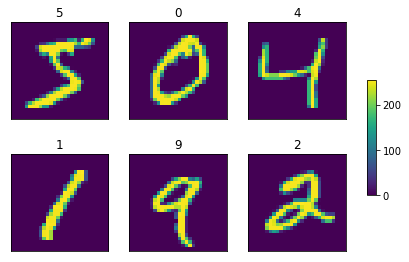

In [9]:
fig = plt.figure()
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.tight_layout()
    im = plt.imshow(example_data[i][0], interpolation='none', vmin=0, vmax=255)
    plt.title("{}".format(example_targets[i]))
    plt.xticks([])
    plt.yticks([])

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.3, 0.02, 0.4])
fig.colorbar(im, cax=cbar_ax)
fig.savefig(folder_fig.joinpath(f'MNIST_samples.pdf'), format='pdf', dpi=300)

## Map to Current (No noise):

Samples shape: torch.Size([300, 784])


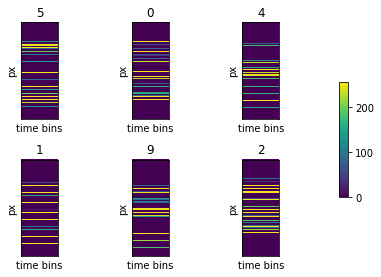

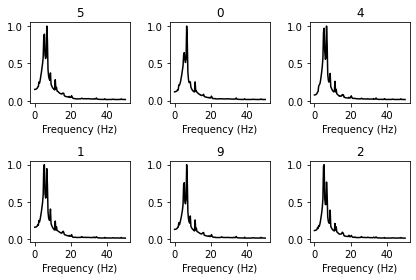

In [10]:
add_noise = False

# Transformation:
stim_len_sec = 3
dt_sec = 1e-2
v_max = 0.2
batch_size_train = 10
batch_size_test = 10

# Train:
train_loader = DataLoader(MNIST(root='data', train=True, download=True, 
                                transform=transforms.Compose([transforms.PILToTensor(), 
                                                              ToCurrent(stim_len_sec, dt_sec, v_max, add_noise=add_noise)])), 
                          batch_size=batch_size_train, 
                          shuffle=shuffle_data, 
                          generator=generator)

# Test:
test_loader = DataLoader(MNIST(root='data', train=False, download=True, 
                               transform=transforms.Compose([transforms.PILToTensor(),
                                                             ToCurrent(stim_len_sec, dt_sec, v_max, add_noise=add_noise)])),
                         batch_size=batch_size_test, 
                         shuffle=shuffle_data, 
                         generator=generator)
# Print samples size:
examples = enumerate(train_loader)
batch_idx, (example_data, example_targets) = next(examples)
print('Samples shape:', example_data[0].shape)

# Plot:
fig = plt.figure()
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.tight_layout()
    im=plt.imshow(torch.transpose(example_data[i], 1,0), interpolation='none', vmin=0, vmax=255+v_max)    
    plt.title("{}".format(example_targets[i]))
    plt.xticks([])
    plt.yticks([])
    plt.xlabel('time bins')
    plt.ylabel('px')

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.3, 0.02, 0.4])
fig.colorbar(im, cax=cbar_ax)
fig.savefig(folder_fig.joinpath(f'MNIST_samples_post_proc.pdf'), format='pdf', dpi=300)

fig = plt.figure()
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.tight_layout()
    xf, y = get_fft(example_data[i], dt_sec)
    plt.plot(xf, y, c='k')
    plt.title("{}".format(example_targets[i]))
    plt.xlabel('Frequency (Hz)')
fig.savefig(folder_fig.joinpath(f'MNIST_samples_post_proc_spectrum.pdf'), format='pdf', dpi=300)

## Map to Current (Add uniform noise):

Samples shape: torch.Size([300, 784])


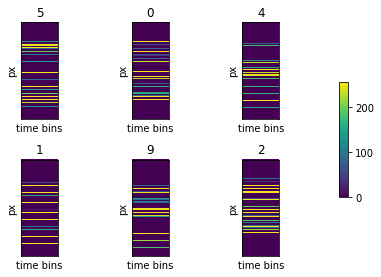

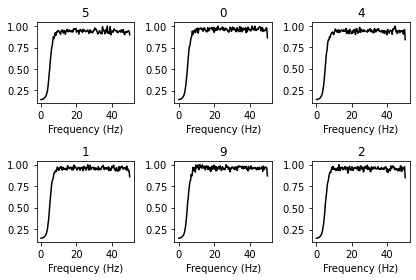

In [11]:
add_noise = True

# Transformation:
stim_len_sec = 3
dt_sec = 1e-2
v_max = 0.2
batch_size_train = 10
batch_size_test = 10

# Train:
train_loader = DataLoader(MNIST(root='data', train=True, download=True, 
                                transform=transforms.Compose([transforms.PILToTensor(), 
                                                              ToCurrent(stim_len_sec, dt_sec, v_max, add_noise=add_noise)])), 
                          batch_size=batch_size_train, 
                          shuffle=shuffle_data, 
                          generator=generator)

# Test:
test_loader = DataLoader(MNIST(root='data', train=False, download=True, 
                               transform=transforms.Compose([transforms.PILToTensor(),
                                                             ToCurrent(stim_len_sec, dt_sec, v_max, add_noise=add_noise)])),
                         batch_size=batch_size_test, 
                         shuffle=shuffle_data, 
                         generator=generator)
# Print samples size:
examples = enumerate(train_loader)
batch_idx, (example_data, example_targets) = next(examples)
print('Samples shape:', example_data[0].shape)

# Plot:
fig = plt.figure()
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.tight_layout()
    im=plt.imshow(torch.transpose(example_data[i], 1,0), interpolation='none', vmin=0, vmax=255+v_max)    
    plt.title("{}".format(example_targets[i]))
    plt.xticks([])
    plt.yticks([])
    plt.xlabel('time bins')
    plt.ylabel('px')

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.3, 0.02, 0.4])
fig.colorbar(im, cax=cbar_ax)
fig.savefig(folder_fig.joinpath(f'MNIST_samples_post_proc_with_noise.pdf'), format='pdf', dpi=300)

fig = plt.figure()
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.tight_layout()
    xf, y = get_fft(example_data[i], dt_sec)
    plt.plot(xf, y, c='k')
    plt.title("{}".format(example_targets[i]))
    plt.xlabel('Frequency (Hz)')
fig.savefig(folder_fig.joinpath(f'MNIST_samples_post_proc_spectrum_with_noise.pdf'), format='pdf', dpi=300)

## Load dataset:

In [12]:
stim_len_sec = 3
dt_sec = 1e-2
batch_size = 100
train_dl, test_dl = load_MNIST(batch_size=batch_size, stim_len_sec=stim_len_sec, dt_sec=dt_sec, v_max=v_max, add_noise=True, return_fft=True)

N samples training: 60000
N samples test: 10000


In [13]:
# Check sample sizes:
examples = enumerate(train_dl)
batch_idx, (example_data, example_targets) = next(examples)
shape = example_data.shape

assert(shape[0]==batch_size)
n_time_steps = int(stim_len_sec/dt_sec)
assert(shape[1]==len(rfftfreq(n_time_steps, dt_sec)))
assert(shape[2]==n_pixels**2)
# shape[0]: batch_size
# shape[1]: freq
# shape[2]: px

# Features dataset

In [4]:
list_datasets = ['Braille', 'MNIST']
#list_datasets = ['Braille']
list_data_types = ['frequency', 'amplitude', 'slope']

<Figure size 432x288 with 0 Axes>

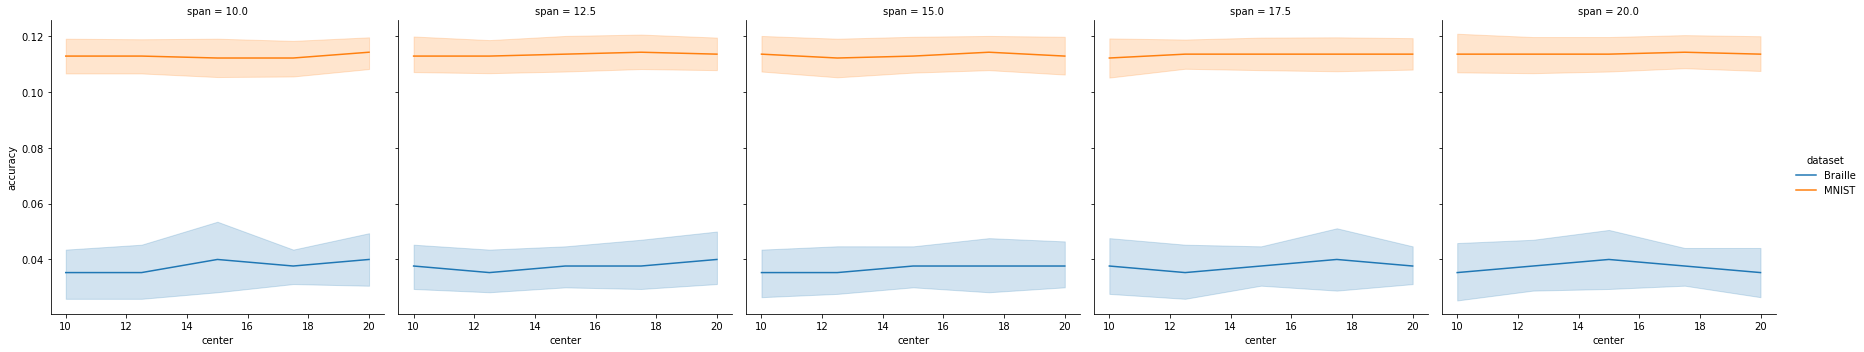

<Figure size 432x288 with 0 Axes>

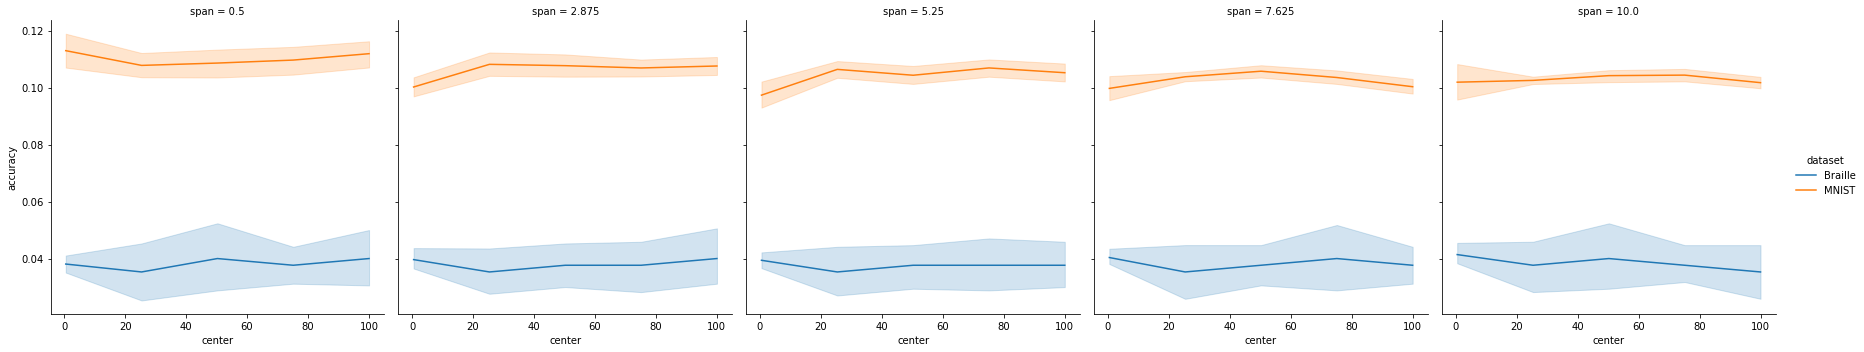

<Figure size 432x288 with 0 Axes>

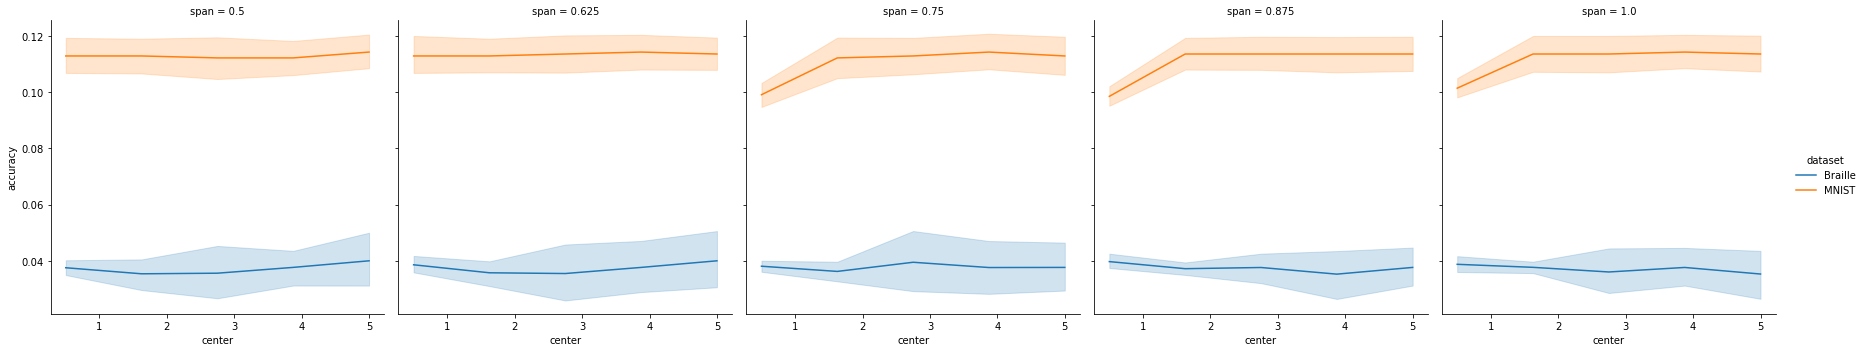

<Figure size 432x288 with 0 Axes>

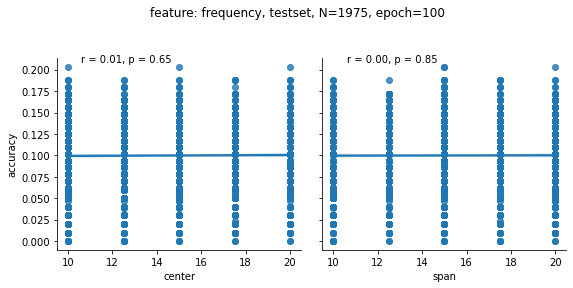

<Figure size 432x288 with 0 Axes>

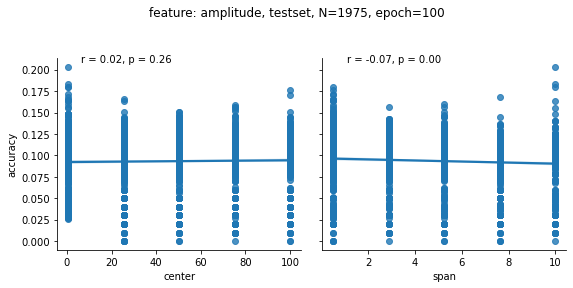

<Figure size 432x288 with 0 Axes>

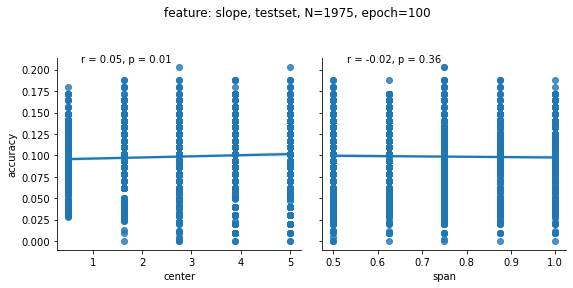

In [5]:
import json
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

data = {'center': [], 'span': [], 'accuracy': [], 'data_type': [], 'dataset': []}
for dataset in list_datasets:
    for data_type in list_data_types:
        filename = f'/media/p308783/bics3/Nicoletta/tactile_encoding/{dataset}/{data_type}.json'
        with open(filename) as f:
            d = json.load(f)
        data['center'].extend(d['center'])
        data['span'].extend(d['span'])
        data['accuracy'].extend(d['accuracy'])
        data['data_type'].extend([data_type]*len(d['accuracy']))
        data['dataset'].extend([dataset]*len(d['accuracy']))
    
data = pd.DataFrame(data)
data.head()

for data_type in list_data_types:
    plt.figure()
    sns.relplot(data=data[data['data_type']==data_type], x="center", y="accuracy", hue="dataset", kind="line", col='span')

from scipy import stats
def corrfunc(x, y, **kws):
    r, p = stats.pearsonr(x, y)
    ax = plt.gca()
    ax.annotate("r = {:.2f}, p = {:.2f}".format(r, p),
                xy=(.1, .98), xycoords=ax.transAxes)
    
for data_type in list_data_types:
    plt.figure()
    g = sns.PairGrid(data=data[data['data_type']==data_type], y_vars=["accuracy"], x_vars=["center", "span"], height=4)
    g.map(sns.regplot)
    g.map(corrfunc)
    g.fig.subplots_adjust(top=0.8) # adjust the Figure in rp
    N = len(d['center'])
    g.fig.suptitle(f'feature: {data_type}, testset, N={N}, epoch=100')

In [25]:
import numpy as np

test_size = 10000
batch_size = 128
n_combinations_center_span = 25
assert len(d['center']) == np.ceil(test_size/batch_size)*n_combinations_center_span

#### **NOTE** Ranges of center and span are not comparable across data types